# BEE 4750 Lab 4: Simulation-Optimization

**Name**:

**ID**:

> **Due Date**
>
> Friday, 11/17/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [47]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/lab04-teaganraesmith`


In [48]:
using Random # for random seeds
using Distributions # statistical distribution interface
using Roots # find zeros of functions
using Metaheuristics # search algorithms
using Plots # plotting

## Overview

In this lab, you will experiment with simulation-optimization with the
shallow lake problem. The goal of this experimentation is to get an
understanding of how to work with simulation-optimization methods and
the impact of some choices involved in using these methods.

Free free to delete some of the illustrative cells and code blocks in
your notebook as you go through and solve the lab problems…this might
help reduce some potential confusion while grading about what your
answer is.

## Introduction

Due to ongoing economic activity, a town emits phosphorous into a
shallow lake (with a concentration of $a_t$), which also receives
non-point source runoff (concentration $y_t$) from the surrounding area.
The concentration of the lake at time $t+1$ is given by
$$X_{t+1} = X_t + a_t + y_t + \frac{X_t^q}{1+X_t^q} - bX_t,$$

where:

| Parameter | Value                                                |
|:---------:|:-----------------------------------------------------|
|   $a_t$   | point-source phosphorous concentration from the town |
|   $y_t$   | non-point-source phosphorous concentration           |
|    $q$    | rate at which phosphorous is recycled from sediment  |
|    $b$    | rate at which phosphorous leaves the lake            |

and $X_0 = 0$, $y_t \sim LogNormal(\log(0.03), 0.25)$, $q=2.5$, and
$b=0.4$.

The goal of the optimization is to maximize the town’s average
phosphorous concentration releases (as a proxy of economic activity):
$\max \sum_{t=1}^T a_t / T$ over a 100-year period. We have decided
(initially) that an acceptable solution is one which will result in the
lake eutrophying no more than 10% of the time.

The non-point source samples can be sampled using the following code
block:

In [49]:
Random.seed!(1)

T = 100 # length of simualtion
n_samples = 1_000 # replace with number of samples if you experiment

P_distribution = LogNormal(log(0.03), 0.25)
y = rand(P_distribution, (T, n_samples)) # sample a T x n_samples matrix

100×1000 Matrix{Float64}:
 0.0294753  0.0459864  0.023513   …  0.0259183  0.0260934  0.0284652
 0.034263   0.0222782  0.0459188     0.0288482  0.0480454  0.0531018
 0.0245199  0.0296271  0.0445619     0.0246404  0.0250734  0.0304308
 0.055448   0.0312     0.0228208     0.0298609  0.0428105  0.0256198
 0.0401417  0.024978   0.0458244     0.0228935  0.0286062  0.0238694
 0.0320754  0.021759   0.0471452  …  0.0472771  0.0187508  0.0306753
 0.0464641  0.0416385  0.0246833     0.0382252  0.0288505  0.0226561
 0.0244027  0.0432707  0.0341214     0.0238988  0.0427204  0.0316143
 0.0231156  0.0279197  0.0217747     0.0231772  0.0335662  0.0324465
 0.0276303  0.0305858  0.0440326     0.0289394  0.0312328  0.0173388
 ⋮                                ⋱                        
 0.025665   0.0341366  0.0274747     0.0283546  0.0458031  0.0277959
 0.0405629  0.0421121  0.0252557     0.0450377  0.0284411  0.0206434
 0.0228445  0.0223746  0.0210942     0.0442834  0.0337672  0.0287835
 0.0252604  0.046

We write the lake model as a function:

In [50]:
# lake function model
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   series of lake phosphorous concentrations
function lake(a, y, q, b, T)
    X = zeros(T+1, size(y, 2))
    # calculate states
    for t = 1:T
        X[t+1, :] = X[t, :] .+ a[t] .+ y[t, :] .+ (X[t, :].^q./(1 .+ X[t, :].^q)) .- b.*X[t, :]
    end
    return X
end

lake (generic function with 1 method)

However, this isn’t sufficient on its own! `Metaheuristics.jl` (and most
simulation-optimization packages) require the use of a *wrapper*
function, which accepts as inputs both parameters to be optimized (in
this case, point-source releases `a`) and parameters which will be fixed
(the others; see below for how to incorporate these into the syntax) and
returns the required information for the optimization procedure.

`Metaheuristics.jl` wants its optimizing wrapper function to return (in
order):

-   the objective(s) (in this case, the mean of `a`, $\sum_t a_t / T$),
-   a vector of the degrees to which the solution fails to achieve any
    inequality constraints (positive values indicate a larger failure,
    values below zero are considered acceptable)
-   a vector of the degrees to which the solution fails to achieve any
    equality constraints (only values of zero indicate success), which
    in this case is not relevant, so we just return `[0.0]`.

In [51]:
# function producing optimization outputs
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   - objective: mean value of point-source releases
#   - inequality constraint failure vector
#   - equality constraint failure vector (in this case, always [0.0])
function lake_opt(a, y, q, b, T, Xcrit)
    X = lake(a, y, q, b, T)
    # calculate exceedance of critical value
    Pexceed = sum(X[T+1, :] .> Xcrit) / size(X, 2)
    failconst = [Pexceed - 0.1] # replace 0.1 if you experiment with the failure probability
    return mean(a), failconst, [0.0]
end

lake_opt (generic function with 1 method)

To optimize using DE (differential evolution), use the following syntax:

``` julia
results = optimize(f, bounds, DE(options=Options(f_calls_limit=max_evals)))
```

where `bounds` is a `Matrix` of lower bounds (first row) and upper
bounds (last row), and `max_evals` is an integer for the maximum number
of evaluations.

-   For example, to set bounds for all decision variables between 0 and
    0.5, you can use

``` julia
bounds = [zeros(T) 0.5ones(T)]'
```

-   Increasing `max_evals` can help you find a better solution, but at a
    larger computational expense.
-   You can use an anonymous function to fix values for non-optimized
    parameters, *e.g.*

``` julia
y = ...
q = ...
b = ...
T = ...
Xcrit = ...
results = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals)))
```

Then to get the approximated minimum value:

``` julia
fx = minimum(result)
```

and the approximated minimizing value:

``` julia
x = minimizer(result)
```

The last piece is to get the critical value (to identify failures),
which we can do using `Roots.jl`, which finds zeros of functions:

In [52]:
q=2.5
b=.4
# define a function whose zeros are the critical values
P_flux(x) = (x^q/(1+x^q)) - b*x
# use Roots.find_zero() to find the non-eutrophication and non-zero critical value; we know from visual inspection in class that this is bounded between 0.1 and 1.5.
Xcrit = find_zero(P_flux, (0.1, 1.5))

0.6678778690448219

## Problems

### Problem 1 (2 points)

Using the default setup above, find the approximate optimum value. What
is the value of the objective function, and how many failures (you can
evaluate the `lake` function using your solution to find how many
end-values are above the critical value).


In [144]:
max_evals=1000; #Any decided maximum evaluation
Random.seed!(1) #Keeps constant value
#y,a,b, xcrit defined above
t = 100
bounds = [zeros(T) 0.5ones(T)] #given bounds
results = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals)))


Optimization Result
===================
  Iteration:       1
  Minimum:         0.210588
  Minimizer:       [0.121521, 0.0485756, 0.399366, …, 0.0721527]
  Function calls:  1000
  Feasibles:       0 / 1000 in final population
  Total time:      3.9435 s
  Stop reason:     Maximum objective function calls exceeded.

In [89]:
fx = minimum(results)

0.21058759608000296

The value of the objective function is 0.2105. This is the approximate minimum value of the function.

In [145]:
x = minimizer(results);

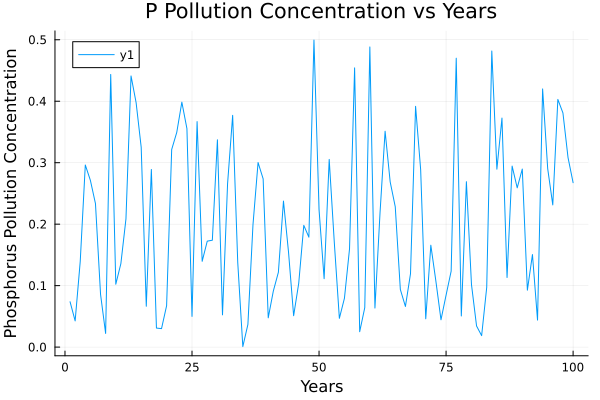

In [87]:
plot(x, xlabel="Years", ylabel="Phosphorus Pollution Concentration", title="P Pollution Concentration vs Years")

In [146]:
lake_opt(x, y, q, b, T, Xcrit)

(0.21058759608000296, [0.9], [0.0])

The fail constant is 0.9. This means that 100% of the end values found from optimization are above the critical value. This is despite putting the maximum evaluations to be 10,000. The bounds were then put back to 1,000 for future trial runs. This could be an issue with the bounds which are adapted in the next problem.

### Problem 2 (5 points)

Feel free to experiment with some of the degrees of freedom in finding
the optimum value. For example:

-   What failure probability are you using to characterize acceptable
    solutions?
-   How many Monte Carlo samples are you using?
-   What bounds are you searching over for the releases?
-   How many function evaluations are you using for the search?
-   What is the impact of different [`Metaheuristics.jl`
    algorithms](https://docs.juliahub.com/Metaheuristics/aJ70z/3.2.12/algorithms/)?

Note that you might want to modify some of these together: for example,
lower acceptable failure probabilities often require more function
evaluations to find acceptable values, and more Monte Carlo samples
increase computational expense, so fewer function evaluations may be
completed in the same time.

Provide a description of what you’ve modified and why. What was the new
solution that you found? Does it satisfy the constraints?

In [136]:
#Trial 1: Monte Carlo
Random.seed!(1)
bounds = [zeros(T) 0.5ones(T)]
max_evals1=10000
results1 = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals1)))

Optimization Result
===================
  Iteration:       10
  Minimum:         0.172509
  Minimizer:       [0.415981, 0.0409771, 0.0683493, …, 0.0688021]
  Function calls:  10000
  Feasibles:       0 / 1000 in final population
  Total time:      36.5494 s
  Stop reason:     Maximum objective function calls exceeded.

In [137]:
x = minimizer(results1);

In [138]:
lake_opt(x, y, q, b, T, Xcrit)

(0.1725090368282208, [0.9], [0.0])

This trial increased the number of evaluations from 1000 to 10,000. This is to converge on an answer because 10,000 trials would be a large enough number to see a difference from prior Monte Carlo examples done in Lab 2. However, this did not change the optimum value, as it was still g=[0.9] indicating that there is no feasible solution. The optimal solution is found here to be 0.1725.

In [109]:
#Trial 2: One Metaheuristic Trial
Random.seed!(1)
results2 = Metaheuristics.optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals)))
results2.best_sol

(f = 2.1059e-01, g = [0.9], h = [0.0], x = [0.121521, 0.0485756, 0.399366, …, 0.0721527])

For this experiment, the modification is to take a more heuristic approach. This is a more approximate optimum value. In this scenario, there was still no feasible solution found because g=[0.9]. This is based on the lecture notes that Metaheuristics are used to iteratively improve a solution to a problem and is used when problems are complex or traditional methods are too slow.

In [140]:
#Trial 3a: Bounds Changes
Random.seed!(1)
bounds = [zeros(T) .3ones(T)]
max_evals3=1000
results3a = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals3)))
#Trial 3b: Bounds Changes
Random.seed!(1)
bounds = [zeros(T) 0.09ones(T)]
results3b = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals3)))
#Trial 3c: Bounds Changes
Random.seed!(1)
bounds = [zeros(T) 0.096ones(T)]
results3c = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals3)))
#Trial 3d: Bounds Changes
Random.seed!(1)
bounds = [zeros(T) 0.1ones(T)]
results3d = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals3)))

Optimization Result
===================
  Iteration:       1
  Minimum:         0.0430381
  Minimizer:       [0.00469103, 0.0624085, 0.0168819, …, 0.0313996]
  Function calls:  1000
  Feasibles:       0 / 1000 in final population
  Total time:      3.7213 s
  Stop reason:     Maximum objective function calls exceeded.

In [125]:
x = minimizer(results3a);

In [126]:
lake_opt(x, y, q, b, T, Xcrit)

(0.12357781121673274, [0.9], [0.0])

In [127]:
x = minimizer(results3b);

In [128]:
lake_opt(x, y, q, b, T, Xcrit)

(0.03534369468806552, [-0.099], [0.0])

In [141]:
x = minimizer(results3c);

In [142]:
lake_opt(x, y, q, b, T, Xcrit)

(0.04131660190381437, [0.093], [0.0])

In [133]:
x = minimizer(results3d);

In [134]:
lake_opt(x, y, q, b, T, Xcrit)

(0.04233763386762095, [0.781], [0.0])

Decreasing bounds of phosphorus concentrations is making a more finite range of tests which allows to increase exactness of solution (increase decimal places of answer). Trial a decreased the bounds to [0,0.3] which had the same value as the trials above, no feasible solution. Trial 2 the bounds were decreased to [0,0.09] in order to increase exactness, however, the percentage came up negative. This indicates that these bounds may be too small to make a feasible solution, as the percentage physically cannot be negative in the example. In trial c, I increased the bounds once again to try to bring it back into realistic numbers, [0,0.096] finally brought the percentage into realistic numbers. The fact that this percentage is so low, means it is more of an optimal solution. In an attempt to get closer to the lowest percentage possible, for trial d, the bounds were [0,0.1], however this percentage went up, indicating that the optimal solution is closer to the bounds [0,0.096]. In these trials, the most optimal solution is 0.0413. This indicates that if I were to do more trials that I would try to change the bounds, changing the lower bound in addition to the upper bound to try to get closer to a lower percentage.

### Problem 3 (3 points)

What did you learn about the use of these methods? Compare with your
experience with linear programming from earlier in the semester.


The Monte Carlo method is often a valuable tool in predicting successes but not always the most reliable. The limitations of the model and assumptions use can greatly impact the accuracy of the model. More trials typically cause greater convergence with monte carlo. We saw this for a fact with the dice rolls in lab 2, and the price is right game. There is a certain evaluation number above which things typically converge. 10,000 is a high enough number of trials in order to show a convergence, so the fact that there is no change depending on the max evalutions showcases that this might not be an issue with number of trials, rather a different limitation in the model.

The heuristic model has a lot of uncertainty and errors as discussed in lecture. They can have inaccurate judgements and bias. This is because it is essentially a best guess form of programming. The positive of this is that I could perform many trials with a very minimal total computing time. The negative, is that I would be less likeley to trust this method if I was to use it in the future in a job. This would be a good method if the solution has a lot of leeway and can have error, not if something needs to be very accurate.

Often in optimization problems, the goal is often to find maximums and minimums subject certain bounds constraints. Changing the bounds helps in finding an area of values which is small enough that the answer can be accurate to a higher degree. The smaller the bounds are around the correct answer, the more decimals the program has access to to determine the accuracy of the answer. In this scenario, the bounds above were decreased until a notable change in accuracy was found around [0,0.096]. If one was to repeat these trials with more time, more trials would need to be done with increasing decimal places trying to create bounds that are most accurate to the problem. In real world modeling scenarios, the bounds could be changed in a loop with many decimal places, not by hand, in order to increase the computing speed and accuracy to determine the answer.

Earlier in the semester we utilized the JuMP algorithm. This method called for many constraints, bounds, and overall more information in order to answer a problem. The positive of that was the method was more accurate, the negative was that in some situations constraints or bounds may be hard to find or decipher in the real world. In that case, a simpler algorithm like is shown in the beginning of this lab may be preferred, so long as the answer does not need to be perfectly accurate or within a certain decimal place of exactness.

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

Emma-Rose Connolly, Gaby the TA

https://www.geeksforgeeks.org/lower-and-upper-bound-theory/#